# Verisetinin hikayesi

Bank Note Authentication UCI veri seti, 2012 yılında Almanya'daki araştırmacıların sahte paraları tespit etmek amacıyla geliştirdiği, fiziksel banknotların matematiksel parmak izlerinden oluşan bir verisetidir. Gerçek ve sahte paraların yüksek çözünürlüklü endüstriyel tarayıcılarla dijitalleştirilmesi ve ardından "Wavelet Dönüşümü" tekniğiyle analiz edilmesiyle oluşturulan bu veri seti; paraların dokusunu varyans, çarpıklık, basıklık ve entropi gibi dört temel sayısal değere indirger. Sonuç olarak, insan gözünün kaçırabileceği mikroskobik doku farklarını makine öğrenmesi algoritmaları için işlenebilir hale getirir.

# Gerekli kütüphaneler

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import mannwhitneyu, shapiro
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import missingno as msno
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.neighbors import KNeighborsClassifier

# Veriseti yüklemesi

In [2]:
df = pd.read_csv('data_banknote_authentication.csv', sep=';')

# 1. Veriye ilk bakış

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   object 
 1   skewness  1372 non-null   object 
 2   curtosis  1372 non-null   object 
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 53.7+ KB
None


Veriseti elemanları hakkında genel bilgi. Sütun ismi, sütunda kaç adet veri olduğu ve değişkenin veri tipi.

In [4]:
print(df.shape)

(1372, 5)


Veriseti kaç sütun ve kaç satırdan oluşuyor. 1372 adet satır, 5 adet sütun mevcut.

In [5]:
print(df.head())

  variance skewness curtosis   entropy  class
0   36.216   86.661  -28.073  -0.44699      0
1   45.459   81.674  -24.586 -14.62100      0
2    3.866  -26.383   19.242   0.10645      0
3   34.566   95.228  -40.112 -35.94400      0
4  0.32924  -44.552   45.718  -0.98880      0


Verisetinin ilk 5 satırını gösterir.

In [6]:
print(df.tail())

     variance  skewness curtosis   entropy  class
1367  0.40614    13.492  -14.501  -0.55949      1
1368  -13.887   -48.773   64.774   0.34179      1
1369  -37.503  -134.586  175.932 -27.77100      1
1370  -35.637   -83.827   12.393 -12.82300      1
1371  -25.419  -0.65804   26.842  11.95200      1


Verisetinin son 5 satırını gösterir.

In [9]:
df.columns = ['varyans', 'çarpıklık', 'basıklık', 'entropi', 'y']

for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

Object olarak gözüken değişkenleri sayısal ifadeye çeviriyoruz. (İleride daha kolay işlem yapabilmek için)

In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   varyans    1369 non-null   float64
 1   çarpıklık  1360 non-null   float64
 2   basıklık   1365 non-null   float64
 3   entropi    1372 non-null   float64
 4   y          1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None


Sayısal ifadeye çevirdiğimiz değişkenleri kontrol ediyoruz. Dönüştürme işlemi başarılı bir şekilde gerçekleşmiş.

# 2. Veri Setinin Betimlenmesi

In [11]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
varyans,1369.0,3.837445,26.879868,-70.421,-15.8510,0.48797,25.58100,68.248
çarpıklık,1360.0,17.494898,56.002524,-137.731,-6.6755,15.14700,61.71075,129.516
basıklık,1365.0,12.339244,41.143078,-52.861,-13.7210,0.57722,27.74200,179.274
entropi,1372.0,-11.475199,20.218128,-85.482,-21.9780,-0.58665,0.39481,24.495
y,1372.0,0.444606,0.497103,0.000,0.0000,0.00000,1.00000,1.000


Eksik gözlemleri göz ardı eder ve verisetindeki değerlerin temel istatistiksel özellikleri analiz eder. 

# 3. Eksik Değerlerin İncelenmesi

In [14]:
df.isnull().values.any()

np.True_

Eksik veri var mı ? Şu an eksik veri var. Çünkü "True" değeri bize geri döndü.

In [15]:
df.isnull().sum()

varyans       3
çarpıklık    12
basıklık      7
entropi       0
y             0
dtype: int64

Hangi değişkende kaç tane eksik veri var?

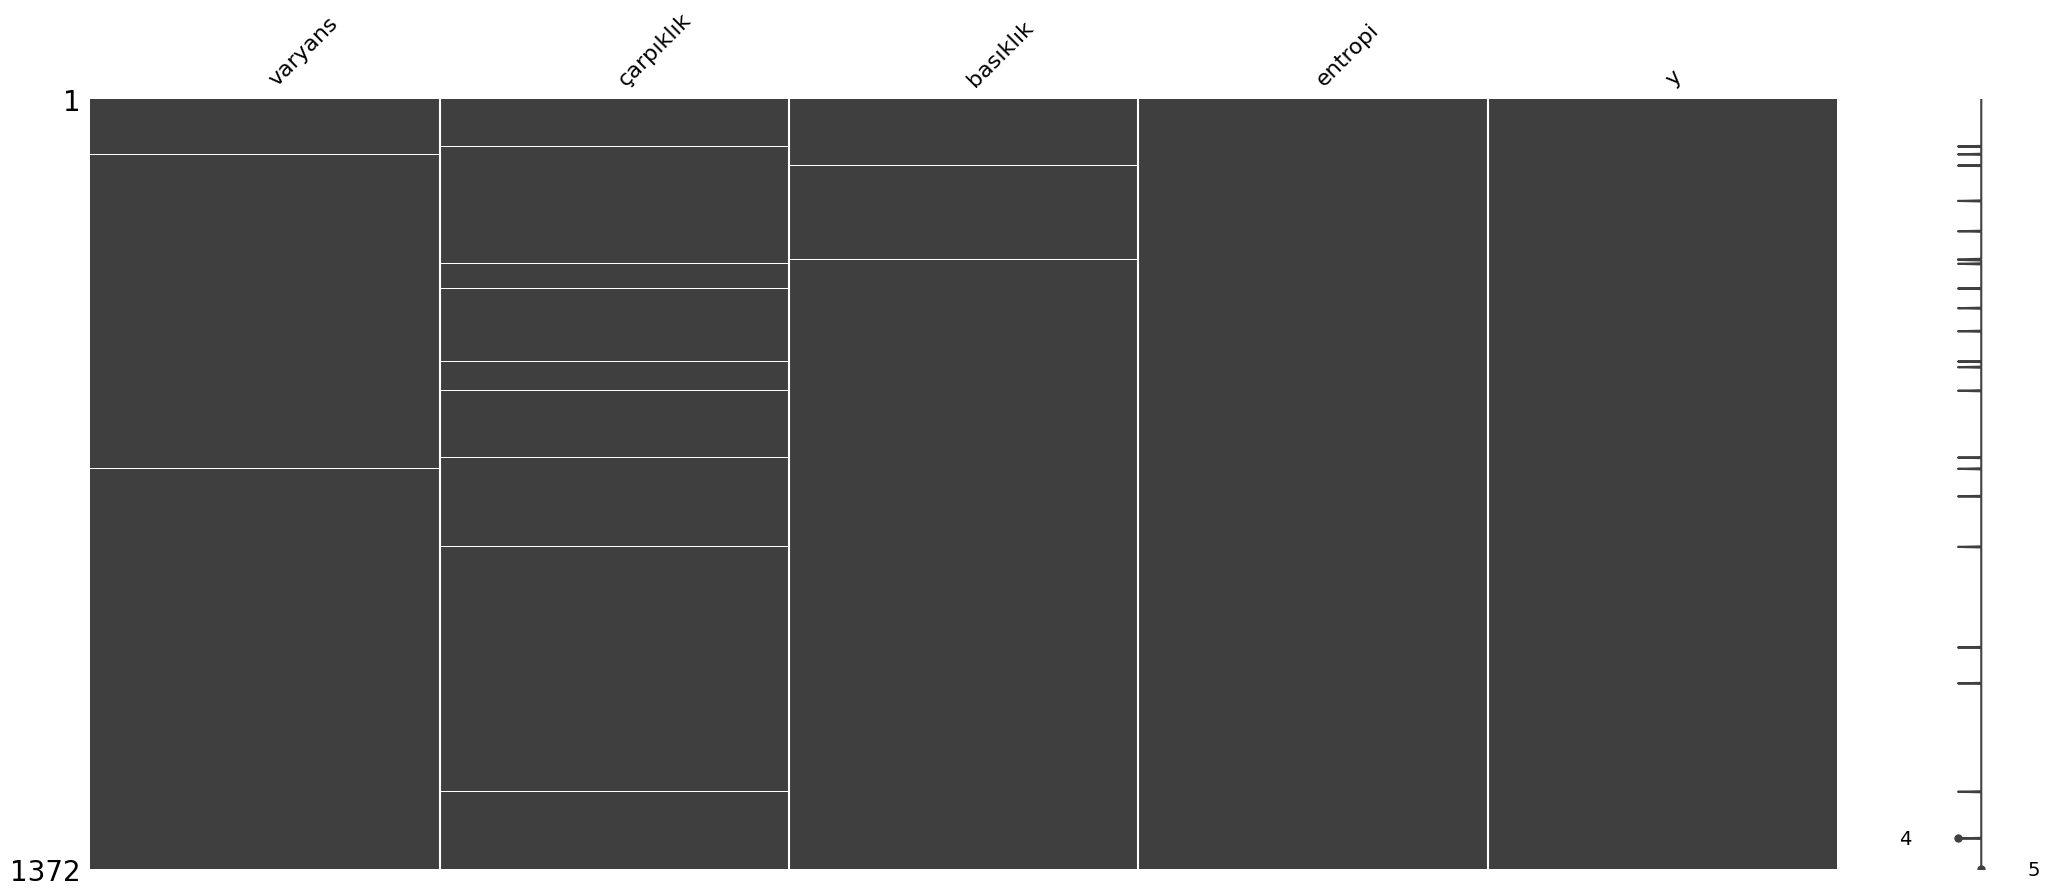

In [16]:
msno.matrix(df);

Verisetindeki eksik verileri matrix üzerinde görüyoruz.

In [17]:
df = df.dropna() 

Eksik veri sayısının toplam veri sayısına oranı çok küçük olduğu için eksik veri bulunan satırların silinmesi tercih edildi.

In [18]:
df.isnull().values.any() # temizlik sonrası eksik veri var mı

np.False_

Silme işlemi sonrasında tekrar eksik veri kontrolü yapıldı. "false" sonucu geri döndü. Şu an veri setinde eksik veri yok.

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
varyans,1350.0,3.767649,26.901019,-70.364,-15.9325,0.417220,25.545000,68.248
çarpıklık,1350.0,17.726523,55.989011,-137.731,-6.5720,15.799000,61.944000,129.516
basıklık,1350.0,12.489055,41.173270,-52.861,-13.6590,0.615345,27.805750,179.274
entropi,1350.0,-11.507259,20.179100,-85.482,-21.9780,-0.588590,0.394487,21.625
y,1350.0,0.448148,0.497488,0.000,0.0000,0.000000,1.000000,1.000


Silme işlemi sonrasında tekrar değişkenlerin temel istatistiksel özellikleri analiz edildi.

# 4. Veri görselleştirme

<Axes: xlabel='y', ylabel='count'>

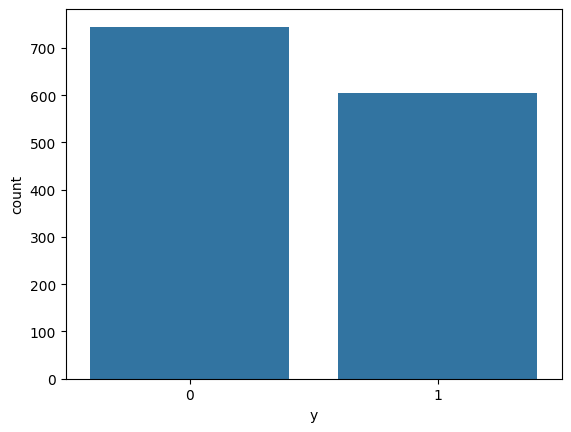

In [20]:
sns.countplot(x='y', data=df)

Bu grafik, sahte ve gerçek banknot sayılarının birbirine yakın olduğunu gösteriyor. Böylelikle dengeli bir model üretebileceğiz. Sahte ve gerçek banknot sayıları birbirine yakın olmasıydı eğiteceğimiz model çoğunluğun olduğu kısma yanlı olacaktı.

<Axes: xlabel='y', ylabel='varyans'>

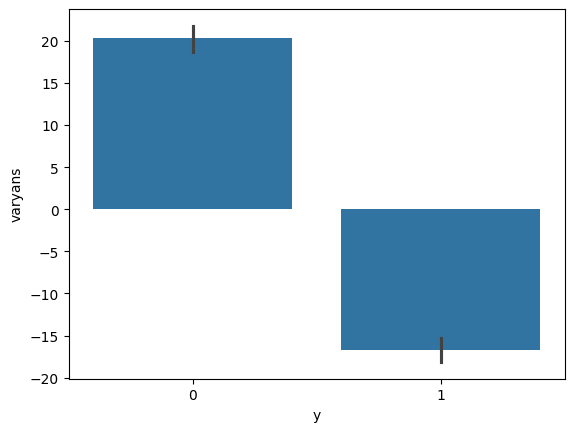

In [22]:
sns.barplot(x='y', y='varyans', data=df)


Bu grafik varyans değişkeni ile sonuç(y) değişkeni arasındaki ilişkiyi ifade etmemizi sağlıyor. Grafiğe baktığımız zaman variance değeri pozitif olanların sahte, variance değeri negatif olanların gerçek banknot olduğunu rahat bir şekilde görebiliyoruz. Modelimizin daha doğru sonuçlar üretmesi için diğer değişkenleri de kontrol edeceğiz.

<Axes: xlabel='y', ylabel='çarpıklık'>

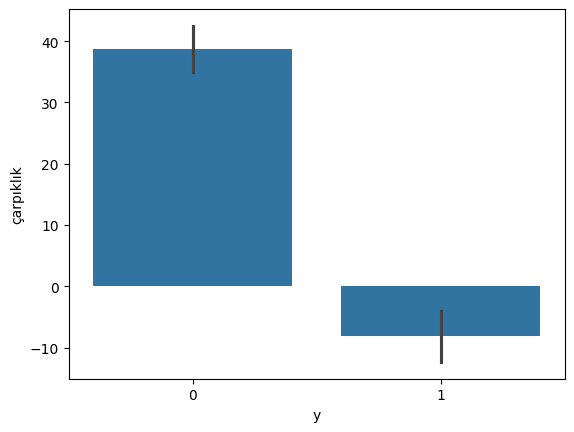

In [23]:
sns.barplot(x='y', y='çarpıklık', data=df)

Bu grafik çarpıklık değişkeni ile sonuç(y) değişkeni arasındaki ilişkiyi ifade etmemizi sağlıyor. Bu grafikte de bir önceki variance grafiğindeki gibi benzer bir durumu görmekteyiz. 

<Axes: xlabel='y', ylabel='basıklık'>

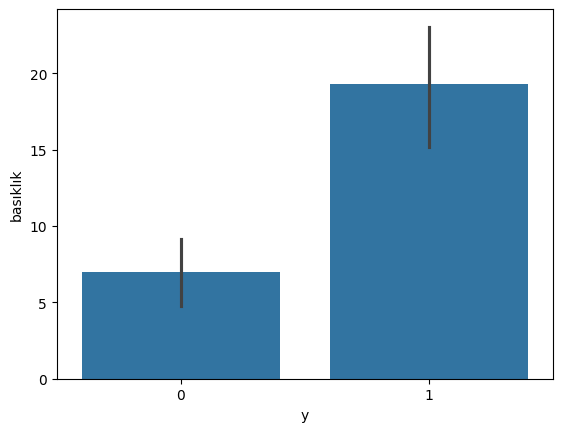

In [27]:
sns.barplot(x='y', y='basıklık', data=df)

Bu grafik basıklık değişkeni ile sonuç(y) değişkeni arasındaki ilişkiyi ifade etmemizi sağlar. Grafiği incelediğiz zaman düşük curtosis değerinde bir çıkarım yapmak mümkün değildir. Çünkü curtosis değeri hem sahte hem de gerçek banknotlar için düşük olabilir. Ancak belli bir değerden yüksek curtosis değeri için gerçek banknot için geçerli olduğunu söyleyebiliriz. 

<Axes: xlabel='y', ylabel='entropi'>

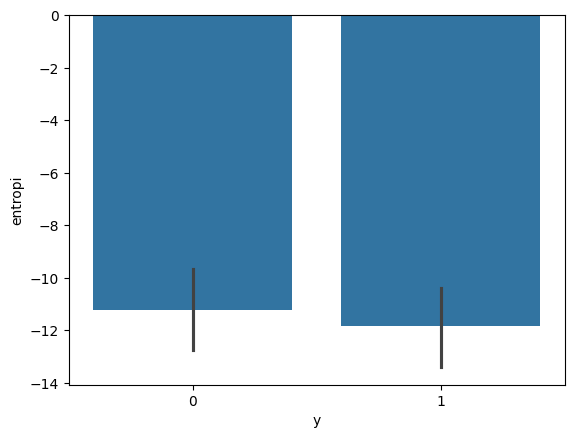

In [28]:
sns.barplot(x='y', y='entropi', data=df)

Bu grafik entropi değişkeni ile sonuç(y) değişkeni arasındaki ilişki ifade etmeizi sağlıyor. Grafiği incelediğimiz zaman entropy değişkeninin değeri hem sahte hem de gerçek banknotlar için nerdeyse aynıdır. Bu yüzden sadece bu grafiği bakarak bir sonuç elde edemeyiz.

<Axes: xlabel='y', ylabel='varyans'>

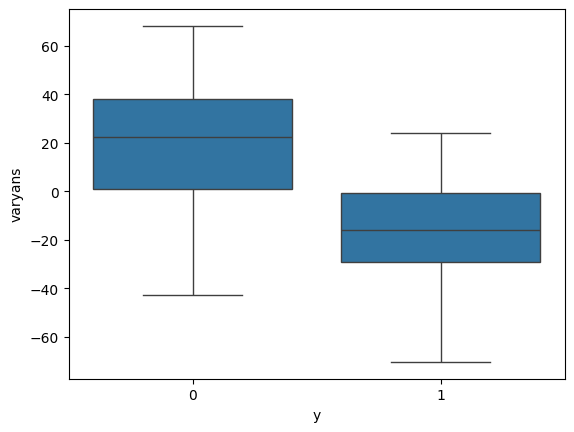

In [29]:
sns.boxplot(x='y', y='varyans', data=df)


Varyans değişkeninin boxplot grafiğine bakınca örtüşmenin çok az olduğu görülmektedir. Bu da varyans değişkeninin ayırt edici bir özellik olduğunu gösterir.

<Axes: xlabel='y', ylabel='çarpıklık'>

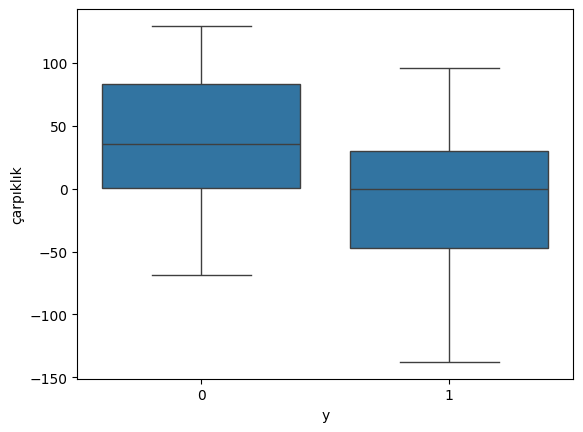

In [30]:
sns.boxplot(x='y', y='çarpıklık', data=df)

Çarpıklık değişkeninin boxplot grafiğine bakınca bir bölümünde örtüşmenin olduğu görülmektedir. Bu da çarpıklık değişkenin  tek başına ayırt edici olmadığını ancak modelin doğruluğuna katkı sağlayabileceğinin gösterir.

<Axes: xlabel='y', ylabel='basıklık'>

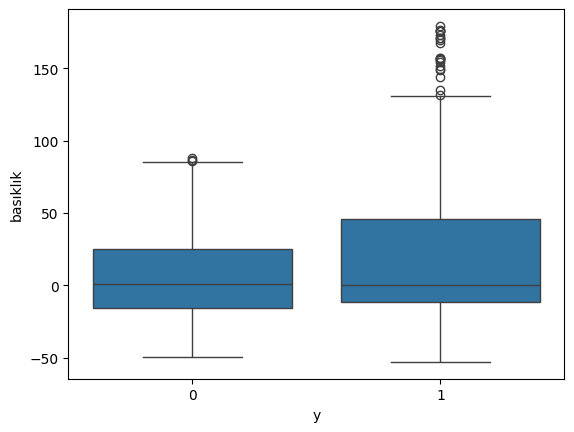

In [33]:
sns.boxplot(x='y', y='basıklık', data=df)

Basıklık değişkeninin boxplot grafiğine bakınca büyük bir bölümde örtüşmenin olduğu görülmektedir. Bu da basıklık değişkeninin ayırt edici olmadığını gösterir. Ama gerçek banknotlarda görülen aşırı yüksek aykırı değerler sayesinde uç durumlar yakalanabilir.

<Axes: xlabel='y', ylabel='entropi'>

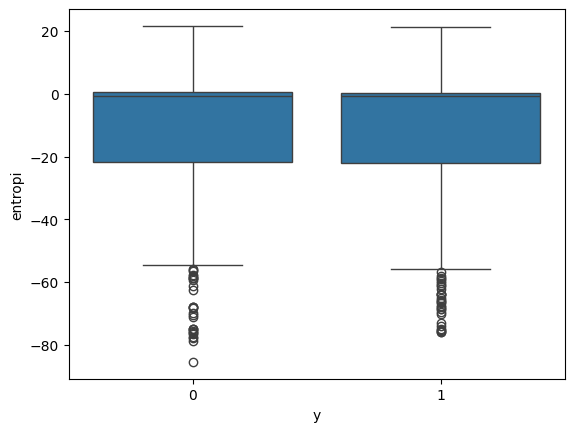

In [32]:
sns.boxplot(x='y', y='entropi', data=df)

Entropi değişkeninin bosplot grafiğine bakınca nerdeyse tamamının hatta aykırı değerlerin bile örtüştüğü görülmektedir. Bu yüzden entropi değişkeni ayırt edici değildir.

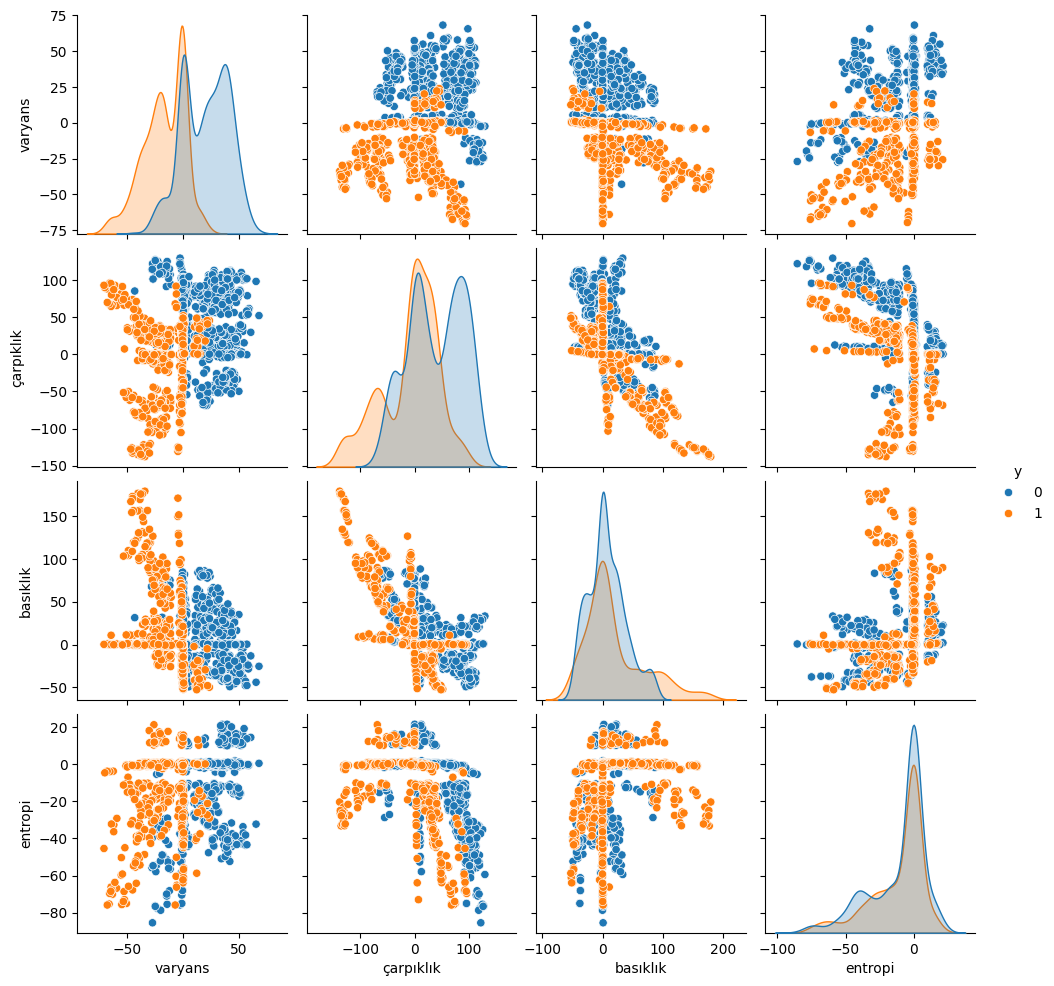

In [34]:
sns.pairplot(df, hue='y') 

Pairplot grafiği sayesinde değişkenler arasındaki ikili ilişkiler incelenebilmektedir. Bu pairplot grafiğine bakılınca entropi değişkeninin ayırt edicilikte zayıf kaldığı, varyans ve çarpıklık ikilisinin daha net bir ayrım sağladığı görülmektedir.

<Axes: >

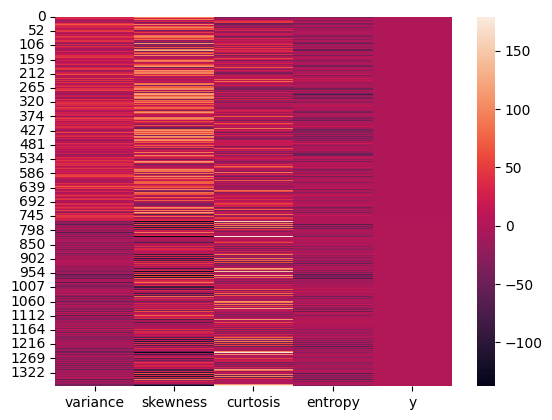

In [26]:
sns.heatmap(df)

# 5. Hipotez testleri

In [ ]:
real_varyans = df[df["y"] == 0]["varyans"]
fake_varyans = df[df["y"] == 1]["varyans"]

stat, p_value = mannwhitneyu(real_varyans, fake_varyans, alternative="two-sided")

print("varyans Testi")
print("p-value:", p_value)

if p_value < 0.05:
    print("Sonuç: Anlamlı fark vardır (H0 reddedildi)")
else:
    print("Sonuç: Anlamlı fark yoktur (H0 reddedilemedi)")

Variance Testi
p-value: 3.494736396270802e-157
Sonuç: Anlamlı fark vardır (H0 reddedildi)


In [ ]:
real_carpiklik = df[df["y"] == 0]["çarpıklık"]
fake_carpiklik = df[df["y"] == 1]["çarpıklık"]

stat, p_value = mannwhitneyu(real_carpiklik, fake_carpiklik, alternative="two-sided")

print("Çarpıklık Testi")
print("p-value:", p_value)

if p_value < 0.05:
    print("Sonuç: Anlamlı fark vardır (H0 reddedildi)")
else:
    print("Sonuç: Anlamlı fark yoktur (H0 reddedilemedi)")

Skewness Testi
p-value: 6.233742062205947e-47
Sonuç: Anlamlı fark vardır (H0 reddedildi)


In [ ]:
real_basiklik = df[df["y"] == 0]["basıklık"]
fake_basiklik = df[df["y"] == 1]["basıklık"]

stat, p_value = mannwhitneyu(real_basiklik, fake_basiklik, alternative="two-sided")

print("Basıklık Testi")
print("p-value:", p_value)

if p_value < 0.05:
    print("Sonuç: Anlamlı fark vardır (H0 reddedildi)") 
else:
    print("Sonuç: Anlamlı fark yoktur (H0 reddedilemedi)")

Curtosis Testi
p-value: 0.10346658009455537
Sonuç: Anlamlı fark yoktur (H0 reddedilemedi)


In [ ]:
real_entropi = df[df["y"] == 0]["entropi"]
fake_entropi = df[df["y"] == 1]["entropi"]

stat, p_value = mannwhitneyu(real_entropi, fake_entropi, alternative="two-sided")

print("Entropi Testi")
print("p-value:", p_value)

if p_value < 0.05:
    print("Sonuç: Anlamlı fark vardır (H0 reddedildi)")
else:
    print("Sonuç: Anlamlı fark yoktur (H0 reddedilemedi)")


Entropy Testi
p-value: 0.28298793947353107
Sonuç: Anlamlı fark yoktur (H0 reddedilemedi)


# 6. Makine Öğrenmesi

# 6.1 Lojistik regresyon (LR)

# 6.1.1 Model

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1350 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   varyans    1350 non-null   float64
 1   çarpıklık  1350 non-null   float64
 2   basıklık   1350 non-null   float64
 3   entropi    1350 non-null   float64
 4   y          1350 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 63.3 KB


In [36]:
df["y"].value_counts()

y
0    745
1    605
Name: count, dtype: int64

In [37]:
y = df["y"]
x = df.drop("y", axis=1)

Tahmin verileri elde edebilmel için sonuç değişkeni ("y") dışındaki değişkenleri almaamız gerekiyor. Bu kodu amacı da budur. "axis=1" ile satır değil sütunlar seçilir.

In [38]:
loj = sm.Logit(y, x)
loj_model = loj.fit()
loj_model.summary()

Optimization terminated successfully.
         Current function value: 0.213336
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1350
Model:                          Logit   Df Residuals:                     1346
Method:                           MLE   Df Model:                            3
Date:                Sat, 03 Jan 2026   Pseudo R-squ.:                  0.6898
Time:                        01:53:19   Log-Likelihood:                -288.00
converged:                       True   LL-Null:                       -928.48
Covariance Type:            nonrobust   LLR p-value:                2.005e-277
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
varyans       -0.1600      0.012    -13.756      0.000      -0.183      -0.137
çarpıklık     -0.0573      0.005    -12.598      0.000      -0.066      -0.048
basıklık      -0.0514      0.004    -11.862      0.000      -0.060      -0.043
entropi       -0.0365      0.006     -5.858      0.000      -0.049      -0.024
==============================================================================
"""

Model tanımlanır ve tüm veriseti ile eğitilir.

Pseudo R-squ. = 0.69 => Bu değer, modelin verideki değişkenlerin %69'unu açıklayabildiğini gösterir.
LLR p-value = 2.005e-277 => Bu değer, modelin istatistiksel olarak anlamlı olduğunu gösterir. Çünkü değer 0.05'ten küçük.

coef (katsayı) => değişkenin sonucu nasıl etkilediğini gösterir. Bu özelliklerin değeri arttıkça y'nin 1 olma ihtimali yükselir.(ters orantı var.) 

P>|z| => Bir değişkenin model için anlamlı olup olmadığını gösterir. Eğer değer 0.05'ten küçükse o değişken anlamlıdır.


In [39]:
loj = LogisticRegression(solver='liblinear')
loj_model = loj.fit(x, y)
loj_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


Model oluşturulur ve eğitilir. Elimizdeki veriseti için "libnier" yeterli olacaktır.

In [40]:
loj_model.intercept_

array([1.5681891])

Lojistik regresyon modelinin sabit değerini gösterir.

In [41]:
loj_model.coef_

array([[-0.17764748, -0.0634233 , -0.06915307, -0.00519652]])

Lojistik regresyon modelinin kat sayılarını gösterir.

# 6.1.2 Tahmin & model tuning

In [42]:
y_pred = loj_model.predict(x)
confusion_matrix(y, y_pred)

array([[687,  58],
       [ 41, 564]])

TP (True Negative)= 687 -- gerçekte 0, model 0 demiş

FN (False Positive)= 58 -- gerçekte 0, model 1 demiş

FP (False Negative)= 41 -- gerçekte 1, model 0 demiş

TN (True Positive)= 147 -- gerçekte  model 1 demiş

Model 1350 verinin sadece 99 tanesinde yanlış sonuç vermiş. Model genel olarak başarılı.

In [51]:
accuracy_score(y, y_pred)

0.9266666666666666

Modelin doğruluğu test edilir. Model %92.6 doğruluk oranı ile çalışıyor.

In [43]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       745
           1       0.91      0.93      0.92       605

    accuracy                           0.93      1350
   macro avg       0.93      0.93      0.93      1350
weighted avg       0.93      0.93      0.93      1350



procision (kesinlik) => 0 için %94 ihtimalle doğru, 1 için %91 ihtimalle doğru.

recall (duyarlılık) => 0 için %92'sini yakalayabilmiş, 1 için %93'ünü yakalayabilmiş.

F1-score => precision ve recall'un ortalamasıdır.

In [ ]:
loj_model.predict(x)[0:10]

array([0, 0, 1, ..., 1, 1, 1], shape=(1350,))

In [46]:
loj_model.predict(x)[1340:1350]

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1])

Verisetinde önce y=0, sonrasında da y=1 olan veriler olduğu için daha doğru bir test için önce verisetin ilk 10 verisini sonra son 10 verisini test edildi. Model yüksek oranda doğru çalışıyor. 

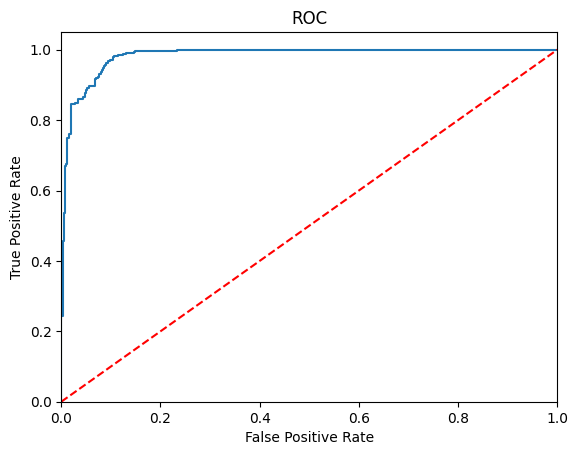

ROC AUC Değeri: 0.9271895279826945


In [47]:
logit_roc_auc = roc_auc_score(y, loj_model.predict(x))

fpr, tpr, thresholds = roc_curve(y, loj_model.predict_proba(x)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc) 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()
print("ROC AUC Değeri:", logit_roc_auc)

ROC grafiği ile modelin doğruluğu görsel olarak sunulmuştur. Kırmızı çizgi %50 doğruluk oranını ifade eder. Amacımız grafikteki mavi çizgiyi sol üst köşeye yakın tutmaktır. Bu modelimizin doğruluğunu gösterir. Şu an grafiğe bakınca modelin doğruluğunun yüksek olduğu görülmektedir. AUC değeri ise model doğruluk oranının sayısal ifadesidir. Model doğruluk oranı: %92.7

# 6.2 K-en yakın komşu (KNN)

# 6.2.1 Model

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

Veriseti eğitim ve test olmak üzere ikiye ayrılır. %30 test kalan %70 eğitim. "random_state=42" veri karıştırılırken kullanılan sabit. Böylelikle kod her çalıştırıldığında tutarlı sonuçlar verir.

In [52]:
knn = KNeighborsClassifier()
knn_model = knn.fit(x_train, y_train)
knn_model

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Öğrenmenin gerçekleştiği kısımdır. KNN sınıflandırıcı modelinden bir örnek alınır ve default ayarlar kullanılır. Daha önce ayrılmış olan "x_train" ve "y_train" verileri ile model eğitilir. 

# 6.2.2 Tahmin & model tuning

In [53]:
y_pred = knn_model.predict(x_test)

"x_test" verileri modele verilir ve tahmin yapması istenir. Modelin tahmin ettiği etiketler "y_pred" değişkenine atanır.

In [54]:
accuracy_score(y_test, y_pred)

0.9530864197530864

Modelin doğruluğu test edilir. Model %95.3 doğruluk oranı ile çalışıyor.

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       217
           1       0.95      0.95      0.95       188

    accuracy                           0.95       405
   macro avg       0.95      0.95      0.95       405
weighted avg       0.95      0.95      0.95       405



procision (kesinlik) => 0 için %96 ihtimalle doğru, 1 için %95 ihtimalle doğru.

recall (duyarlılık) => 0 için %95'sini yakalayabilmiş, 1 için %95'ünü yakalayabilmiş.

F1-score => precision ve recall'un ortalamasıdır.

In [56]:
knn_params = {"n_neighbors": np.arange(1, 50)}

Bu kod ile komşu sayısı için en iyi değer aranıyor. Aralık olarak 1'den 50'ye kadar verildi.

In [57]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(x_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': array([ 1, 2..., 47, 48, 49])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,np.int64(1)


En iyi komşu sayısı değerini belirlemek için parametre aralığındaki tüm kombinasyonlar denenir. 

In [58]:
print("En iyi skor:" + str(knn_cv.best_score_))
print("En iyi parametreler: " + str(knn_cv.best_params_))

En iyi skor:0.9756662933930572
En iyi parametreler: {'n_neighbors': np.int64(1)}


İlk başta %95 olan doğruluk oranı optimizasyon sonrasında %97.5'e çıkmıştır. Ayrınca algoritma, en yakın tek bir komşuya bakarak karar verdiğinde en doğru sonucu elde etmiştir.

In [59]:
knn = KNeighborsClassifier(1)
knn_tuned = knn.fit(x_train, y_train)

Bulunan en iyi parametre ile model tekrar eğitilir.

In [60]:
y_pred = knn_tuned.predict(x_test)

Tekrar eğitilen modele test verileri tekrardan verilir. Etiketler "y_pred" değişkenine atanır. 

In [61]:
accuracy_score(y_test, y_pred)

0.9703703703703703

Tekrar eğitilinen modelin doğruluk skoru ölçülür. Sonuç olarak modelin başarı oranı %95.3'ten %97'ye çıkarılmıştır. 

# 6.3 Destek vektör sınıflandırıcı (SVC)

# 6.3.1 Model

In [64]:
svm_model = SVC(kernel = "linear").fit(x_train, y_train)

Daha önce KNN modeli için ayrılmış olan eğitim verisini burada tekrardan kullanıyoruz.

In [70]:
svm_model

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Bir svm modeli tanımlanır.

# 6.3.3 Tahmin & model tuning

In [66]:
y_pred = svm_model.predict(x_test)

Svm modeline test verileri verirerek bir tahminde bulunması beklenir. Tahmin sonuçları "y_pred" değişkenine atanır.

In [67]:
accuracy_score(y_test, y_pred)

0.9234567901234568

Modelin doğruluk oranı ölçülür. Modelin doğruluk oranı: %92.3

In [68]:
svc_params = {"C": [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100],
              "gamma": [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100]}

"C" parametresi ile modelin hataya ne kadar tolerans göstereceği belirlenir. Küçük c hatalara izin veir, büyük C hata yapmamaya çalışır.

"gamma" parametresi ile tek bir veri noktasının etki alanı belirlenir. Küçük gamma değerinde uzak noktaların da sınır çizimine etkisi varken büyük gamma değerinde sadece sınıra çok yakın noktalar dikkate alınır.

In [71]:
svc = SVC()
svc_vc_model = GridSearchCV(svc, svc_params, 
                            cv=10,
                            n_jobs=-1,
                            verbose=2)

svc_vc_model.fit(x_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


,estimator,SVC()
,param_grid,"{'C': [0.0001, 0.001, ...], 'gamma': [0.0001, 0.001, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


"cv=10" ifadesi ile her kombinasyon 10 kez eğitilip test edilir. 

"n_jobs=-1" ifadesi ile işlemciye "tüm çekirdekleri kullan" emri verilir.

"verbose=2" ifadesi ile işlem sürerken ekrana detaylı bilgi yazılması sağlanır.

**Model için en iyi parametrelerin tespit edilmesi amaçlanmaktadır.**

In [90]:
print("En iyi parametreler: " + str(svc_vc_model.best_params_))

En iyi parametreler: {'C': 10, 'gamma': 0.001}


En iyi parametreler tespit edilmiştir.

In [93]:
svc_tuned = SVC(C=10, gamma=0.001).fit(x_train, y_train)

En iyi parametreler ile model tekrar eğitilir.

In [92]:
y_pred = svc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9703703703703703

Tekrar eğitilinen modelin doğruluk oranı ölçülür. Doğruluk oranı %92.3'den %97.0'a yükselmiştir.

# 6.4 Random Forest (RF)

# 6.4.1 Model

In [99]:
rf_model = RandomForestClassifier().fit(x_train, y_train)

Daha önce ayrılan eğitim verisi bu model için de kullanılmaktadır. Model eğitilir.

# 6.4.2 Tahmin & model tuning

In [101]:
y_pred = rf_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9851851851851852

Eğitilen modelin doğruluk oranı ölçülür. Doğruluk oranı: %98.5

In [105]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [1,2,3,4],
            "n_estimators": [10,100],
            "min_samples_split": [2,5,10]}

max_depth = modelde ağaçların ne kadar derine ineceği belirlenir. Ağaç çok derin olursa veriyi ezberler, sığ olursa model öğrenemez.

max_features = modelin her bir dal ayrılırken kaç farklı özelliğe bakacağını söyler. Rastgeliliği sağlar. 

n_estimators = modelde kaç tane ağaç olacağı belirlenir. Ağaç sayısı arttıkça doğruluk artar ancak işlem süresi uzar.

min_samples_split = modelin bir dalı ayırmak için kaç tane veriye ihtiyaç duyacağı belirlenir.

In [106]:
rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model,
                            rf_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=2)

In [107]:
rf_cv_model.fit(x_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [2, 5, ...], 'max_features': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [10, 100]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,10
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


En iyi parametreyi bulmak amaçlanmaktadır.

In [108]:
print("En iyi parametre: " + str(rf_cv_model.best_params_))

En iyi parametre: {'max_depth': 8, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}


En iyi parametreler bulunmuştur.

In [109]:
rf_tuned = RandomForestClassifier(max_depth=8,
                                  max_features=2,
                                  n_estimators=100,
                                  min_samples_split=2)

rf_tuned.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,2
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Bulunan en iyi parametreler ile model tekrar eğitilmiştir.

In [110]:
y_pred = rf_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9827160493827161

En iyi parametreler ile eğitilen modelin doğruluk oranı ölçülmüştür. Doğruluk oranı %98.5'den %98.2'ye düşmüştür.

In [111]:
Importence = pd.DataFrame({"Importance": rf_tuned.feature_importances_},
                            index = x_train.columns )

Text(0.5, 0, 'Değişken Önem Düzeyi')

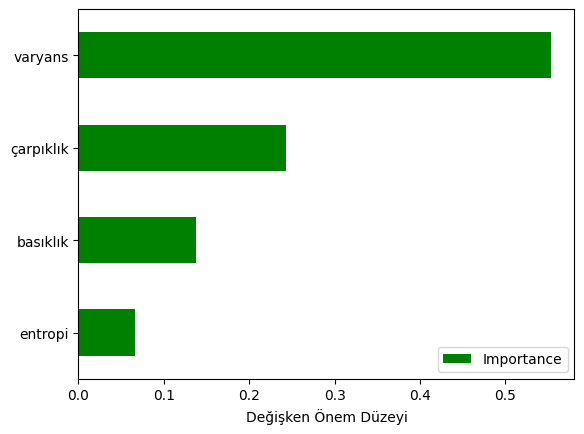

In [112]:
Importence.sort_values(by="Importance",
                       axis = 0,
                       ascending=True).plot(kind='barh', color='green')

plt.xlabel('Değişken Önem Düzeyi')

Değişkenlerin önem düzeyleri grafik ile gösterilmektedir.

# 7. Sonuç

Lojistik Regresyon (LR) -- %92.7

K-En Yakın Komşu (KNN) -- %97

Destek Vektör Sınıflandırıcı (SVC) -- % 97

Random Forest (RF) -- %98.5

%98 doğruluk oranı ile en doğru sonucu veren model RF'dir. Ancak modelin eğitilmesinin çok uzun sürmesi en büyük dezavantajıdır.